**COLLECTING DATA FROM NBA API**

**imports**

In [1]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import BoxScoreSummaryV2
from nba_api.stats.endpoints import BoxScoreAdvancedV2
import pandas as pd
import time
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from ydata_profiling import ProfileReport


c:\Users\Jedrzej\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Pozyskiwanie danych

**We gather information about every team that has ever played in the NBA**

**For each team, we search for associated BoxScores**

In [ ]:
nba_teams = teams.get_teams()
for team in nba_teams:
    team_id = team['id']
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)
    games = gamefinder.get_data_frames()[0]
    games.to_csv('team-games/nba_games.csv', mode='a')

**Filtering the dataset to include only games after 2003**

In [ ]:
df = pd.read_csv('team-games/nba_games.csv')
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], errors='coerce')
df = df[df['GAME_DATE'].dt.year >= 2003]

In [ ]:
# remove duplicates, add leading zeros to GAME_ID

df = pd.read_csv('team-games/nba_games_filtered.csv')
df['GAME_ID'] = df['GAME_ID'].apply(lambda x: f'00{x}')
df_unique = df.drop_duplicates(subset=['GAME_ID'])

* **Currently, the data does not include information about which team is the home team.**
* **We're referring back to the API to obtain the team ID for the home team for each game.**

In [ ]:
def get_data_with_timeout(game_id):
    """
    Function to retrieve data for a given game ID with a timeout.
    """
    response = BoxScoreSummaryV2(game_id=game_id)
    return response.get_data_frames()[7]

def get_home_team_ids(game_ids):
    """
    Function to retrieve home team IDs for a list of game IDs.
    """
    game_home = {}
    for game_id in game_ids:
        game_id_str = f"{game_id:010d}"  # Convert game ID to string format with leading zeros
        try:
            data = get_data_with_timeout(game_id_str)
            home_team_id = data['HOME_TEAM_ID'][0]
            game_home[game_id_str] = home_team_id
        except Exception as e:
            print(f"Error occurred for game_id {game_id_str}: {str(e)}")
    return game_home

# Read unique game IDs from the CSV file
unique_game_ids = pd.read_csv('nba_games_filtered_unique.csv')['GAME_ID'].unique()

# Retrieve home team IDs
game_home = get_home_team_ids(unique_game_ids)

# Convert dictionary to DataFrame and save to CSV
df = pd.DataFrame(list(game_home.items()), columns=['GAME_ID', 'HOME_TEAM_ID']) 
df.to_csv('game_home.csv', index=False)


**Obtaining Missing IDs**

In [ ]:
obtained_games = pd.read_csv('game_home.csv')['GAME_ID'].unique()
all_games = pd.read_csv('nba_games_filtered_unique.csv')['GAME_ID'].unique()
games_to_get = list(set(all_games) - set(obtained_games))

game_home = get_home_team_ids(games_to_get)

df = pd.DataFrame(list(game_home.items()), columns=['GAME_ID', 'HOME_TEAM_ID'])
df.to_csv('game_home.csv', mode='a', header=False, index=False)


**Dropping non-numeric columns. Iterating through the dataset, calculating the average values of statistics for the last 10 games.**

In [7]:
# each row has to contain information about n last games of the team


df = pd.read_csv('nba_games_filtered.csv')
df = df.sort_values(by='GAME_DATE')

columns_to_be_dropped = ['Unnamed: 0', 'SEASON_ID', 'TEAM_ID',
                         'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
                         'GAME_DATE', 'MATCHUP', 'WL', 'MIN']

for season in df['SEASON_ID'].unique():
    season_df = df[df['SEASON_ID'] == season]
    season_df = season_df.sort_values(by='GAME_DATE')

    for index, row in season_df.iterrows():
        team_id = row['TEAM_ID']

        recent_games = season_df[(season_df['TEAM_ID'] == team_id) 
                                & (season_df['GAME_DATE'] < row['GAME_DATE'])
                                ].sort_values(by='GAME_DATE').tail(5)
        
        averages = recent_games.drop(columns=columns_to_be_dropped
                                     ).mean().round(2)

        for column in averages.index:
            df.at[index, column] = averages[column]

df.to_csv('avarages_separate.csv', index=False)


**Introducing a column to store the team's record - Wins-Losses**

In [8]:
# adding new column with team record (wins-loses)

def calculate_team_record(team_id, game_date, season_df):
    past_games = season_df[(season_df['TEAM_ID'] == team_id) 
                          & (season_df['GAME_DATE'] < game_date)]
    
    wins = past_games[past_games['WL'] == 'W'].shape[0]
    loses = past_games[past_games['WL'] == 'L'].shape[0]

    return wins, loses

df = pd.read_csv('avarages_separate.csv')

for season in df['SEASON_ID'].unique():
    season_df = df[df['SEASON_ID'] == season]
    season_df = season_df.sort_values(by='GAME_DATE')

    for index, row in season_df.iterrows():
        team_id = row['TEAM_ID']
        game_date = row['GAME_DATE']

        wins, loses = calculate_team_record(team_id, game_date, season_df)

        df.at[index, 'W-L'] = f'{wins}-{loses}'
   
df.to_csv('avarages_separate.csv', index=False)

**Dropping unnecessary columns**

In [ ]:
# cleaning unnecessary columns and rows with missing values

df = df.sort_values(by='GAME_DATE')
df = df.dropna(axis=1)
df.drop(columns=['Unnamed: 0', 'TEAM_ABBREVIATION', 'MATCHUP'], inplace=True)

* **Previously, data for a single game was stored in 2 records.**
* **Each of them provided the perspective of a specific team for one match.**
* **Below, we want to merge two records into one, with the statistics of the home team marked with the prefix 'H' and the away team with 'A'.**

In [34]:
df = pd.read_csv('avarages_separate5.csv')
home_teams = pd.read_csv('game_home.csv')
shared_columns = ['GAME_ID', 'GAME_DATE', 'SEASON_ID']
dfs = []

for game_id in df['GAME_ID'].unique():
    match = df[df['GAME_ID'] == game_id]

    try:
        home_team_id = home_teams[home_teams['GAME_ID'] == game_id]['HOME_TEAM_ID'].values[0]
    except Exception as e:
        continue

    home_team = match[match['TEAM_ID'] == home_team_id]
    away_team = match[match['TEAM_ID'] != home_team_id]

    home_team.columns = ['H' + col if col not in shared_columns 
                         else col for col in home_team.columns]
    away_team.columns = ['A' + col if col not in shared_columns 
                         else col for col in away_team.columns]

    dfs.append(pd.merge(home_team, away_team, on=shared_columns))

final_df = pd.concat(dfs, ignore_index=True)
final_df.to_csv('merged_avg.csv', index=False)


**Renaming columns to improve dataset readability**

In [10]:
# renaming columns to make them more readable

columns = [ 'SEASON_ID','GAME_ID', 'HTEAM_ID','ATEAM_ID',
            'HTEAM_NAME', 'ATEAM_NAME','GAME_DATE', 'HWL',
            'HW-L', 'AW-L', 'HMIN', 'HPTS', 'HFGM', 'HFGA',
            'HFG_PCT', 'HFG3M', 'HFG3A', 'HFG3_PCT', 'HFTM',
            'HFTA', 'HFT_PCT', 'HOREB', 'HDREB', 'HREB', 'HAST', 'HSTL',
            'HBLK', 'HTOV', 'HPF', 'HPLUS_MINUS',   
            'AWL', 'AMIN', 'APTS', 'AFGM', 'AFGA', 'AFG_PCT', 
            'AFG3M', 'AFG3A','AFG3_PCT', 'AFTM', 'AFTA', 
            'AFT_PCT', 'AOREB', 'ADREB', 'AREB', 'AAST',
            'ASTL', 'ABLK', 'ATOV', 'APF', 'APLUS_MINUS']

df = pd.read_csv('merged_avg5.csv')
df = df.reindex(columns=columns)
df.to_csv('merged_avg.csv', index=False)

* **Declaration of necessary functions for introducing Elo point ranking**
* **Win probability**
* **Coefficient K as a variable constant in formulas**
* **Function updating Elo after the end of a given match**

In [11]:
# declaring functions nessessary for ELO rating system implementation


def calculate_win_probabilities(home_elo, away_elo, home_court_advantage):
    home_rating = 10 ** (home_elo / 400)
    away_rating = 10 ** (away_elo / 400)
    home_advantage = 10 ** (home_court_advantage / 400)

    denominator = away_rating + home_advantage * home_rating
    home_win_probability = home_advantage * home_rating / denominator
    away_win_probability = away_rating / denominator

    return home_win_probability, away_win_probability


def calculate_home_odds(home_elo, away_elo, home_court_advantage):
    home_rating = 10 ** (home_elo / 400)
    away_rating = 10 ** (away_elo / 400)
    home_advantage = 10 ** (home_court_advantage / 400)
    
    return home_advantage * home_rating / away_rating



def calculate_k_factor(margin_of_victory, elo_difference):
    base_k = 20
    if margin_of_victory > 0:
        factor = (margin_of_victory + 3) ** 0.8 / (7.5 + 0.006 * elo_difference)
    else:
        factor = (abs(margin_of_victory) + 3) ** 0.8 / (7.5 + 0.006 * abs(elo_difference))
        
    return base_k * factor



def update_elo_ratings(home_score, away_score, home_elo, away_elo, 
                       home_court_advantage):
    home_win_prob, away_win_prob = calculate_win_probabilities(home_elo, away_elo, 
                                                               home_court_advantage)

    if home_score > away_score:
        home_result = 1
        away_result = 0
    else:
        home_result = 0
        away_result = 1

    k_factor = calculate_k_factor(home_score - away_score, home_elo - away_elo)

    new_home_elo = home_elo + k_factor * (home_result - home_win_prob)
    new_away_elo = away_elo + k_factor * (away_result - away_win_prob)

    return new_home_elo, new_away_elo


In [12]:
df

,SEASON_ID,GAME_ID,HTEAM_ID,ATEAM_ID,HTEAM_NAME,ATEAM_NAME,GAME_DATE,HWL,HW-L,AW-L,...,AFT_PCT,AOREB,ADREB,AREB,AAST,ASTL,ABLK,ATOV,APF,APLUS_MINUS
0,22002,20200448,1610612737,1610612748,Atlanta Hawks,Miami Heat,2003-01-01,L,0-0,0-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22002,20200449,1610612752,1610612761,New York Knicks,Toronto Raptors,2003-01-01,W,0-0,0-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22002,20200450,1610612741,1610612764,Chicago Bulls,Washington Wizards,2003-01-02,L,0-0,0-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22002,20200452,1610612756,1610612755,Phoenix Suns,Philadelphia 76ers,2003-01-02,W,0-0,0-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22002,20200451,1610612742,1610612746,Dallas Mavericks,Los Angeles Clippers,2003-01-02,W,0-0,0-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30578,42023,42300152,1610612743,1610612747,Denver Nuggets,Los Angeles Lakers,2024-04-22,W,1-0,0-1,...,0.90,6.0,34.0,40.0,22.0,3.0,7.0,12.0,15.0,-11.0
30579,42023,42300112,1610612752,1610612755,New York Knicks,Philadelphia 76ers,2024-04-22,W,1-0,0-1,...,0.91,9.0,24.0,33.0,17.0,8.0,7.0,11.0,21.0,-7.0
30580,42023,42300122,1610612749,1610612754,Milwaukee Bucks,Indiana Pacers,2024-04-23,L,1-0,0-1,...,0.67,14.0,36.0,50.0,20.0,4.0,5.0,12.0,16.0,-15.0
30581,42023,42300172,1610612746,1610612742,LA Clippers,Dallas Mavericks,2024-04-23,L,1-0,0-1,...,0.76,9.0,32.0,41.0,14.0,7.0,9.0,8.0,15.0,-12.0


* **Initializing teams with a ranking of 1500.**
* **Then iterating through the dataset to introduce Elo points for each game.**
* **In case of the end of the season, points are not reset but transferred according to new_rating = (0.75 * elo_rating) + (0.25 * 1505)**

In [16]:
# iterating over all games and calculating elo rating for each team
df = pd.read_csv('merged_avg5.csv')

def was_added(teamname, elos):
    for elo in elos:
        if elo['hteam'] == teamname or elo['ateam'] == teamname:
            return True
    return False

def get_prev_elo(teamname, date, season, stats, elos):
    prevg = stats[(stats['GAME_DATE'] < date) 
                  & ((stats['HTEAM_NAME'] == teamname) 
                  | (stats['ATEAM_NAME'] == teamname))].tail(1)

    gameid = prevg['GAME_ID'].values[0]

    if teamname == prevg['HTEAM_NAME'].values[0]:
        elo_key = 'h_elo_after'
    else:
        elo_key = 'a_elo_after'

    for elo in elos:
        if elo['gameid'] == gameid:
            elo_rating =  elo[elo_key]
    
    if prevg['SEASON_ID'].values[0] != season:
        return (0.75 * elo_rating) + (0.25 * 1505)
    else:
        return elo_rating

        


elos = []
df = df.sort_values(by='GAME_DATE', ascending=True)


for index, row in df.iterrows():
    gameid = row['GAME_ID']
    season = row['SEASON_ID']
    hteam, ateam = row['HTEAM_NAME'], row['ATEAM_NAME']
    hscore, ascore = row['HPTS'], row['APTS']
    date = row['GAME_DATE']


    if was_added(hteam, elos):
        helo = get_prev_elo(hteam, date, season, df, elos)
        print(helo)
    else:
        helo = 1500

    if was_added(ateam, elos):
        aelo = get_prev_elo(ateam, date, season, df, elos)
    else:
        aelo = 1500

    helo_after, aelo_after = update_elo_ratings(hscore, ascore, helo, aelo, 100)

    row = {'gameid' : gameid, 'hteam' : hteam, 'ateam' : ateam,
            'date' : date, 'h_elo_before' : helo, 'a_elo_before' : aelo, 
            'h_elo_after' : helo_after, 'a_elo_after' : aelo_after}
    
    elos.append(row)

pd.DataFrame(elos).to_csv('elo.csv', index=False)


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

**Merging Elo system data with the rest of the dataset**

In [ ]:
# merging elo ratings with other statistics

df_stats = pd.read_csv('merged_avg.csv')
df_elo = pd.read_csv('elo.csv')

df_elo  = df_elo.drop(columns=['date', 'hteam', 'ateam'])
df = pd.merge(df_stats, df_elo, left_on='GAME_ID', right_on='gameid')
df.dropna(inplace=True)
df.to_csv('final.csv', index=False)

**Removing redundant and unnecessary columns**

In [75]:
# dropping unnecessary columns

df = pd.read_csv('final.csv')
df = df.drop(columns = ['HFG3_PCT', 'AFG3_PCT', 'HFT_PCT', 'AFT_PCT', 'AWL', 'gameid', 'h_elo_after', 'a_elo_after'])
df.to_csv('final1.csv', index=False)

**Converting team records to numerical values**

In [81]:
# splitting W-L columns into two separate columns


df = pd.read_csv('final1.csv')
for index, row in df.iterrows():
    hwl = row['HW-L']
    awl = row['AW-L']
    hwl = hwl.split('-')
    awl = awl.split('-')
    df.at[index, 'HW'] = int(hwl[0])
    df.at[index, 'HL'] = int(hwl[1])
    df.at[index, 'AW'] = int(awl[0])
    df.at[index, 'AL'] = int(awl[1])
df = df.drop(columns=['HW-L', 'AW-L'])
df.to_csv('final1.csv', index=False)

# EXPLOATORY DATA ANALYSIS

In [77]:
df

,SEASON_ID,GAME_ID,HTEAM_ID,ATEAM_ID,HTEAM_NAME,ATEAM_NAME,GAME_DATE,HWL,HW-L,AW-L,...,ADREB,AREB,AAST,ASTL,ABLK,ATOV,APF,APLUS_MINUS,h_elo_before,a_elo_before
0,22002,20200468,1610612741,1610612739,Chicago Bulls,Cleveland Cavaliers,2003-01-04,W,0-1,1-0,...,34.0,45.0,14.0,9.0,10.0,21.0,24.0,1.0,1475.457475,1504.999432
1,22002,20200465,1610612753,1610612751,Orlando Magic,New Jersey Nets,2003-01-04,L,0-1,1-0,...,33.0,44.0,24.0,15.0,5.0,24.0,24.0,20.0,1492.073249,1522.826167
2,22002,20200463,1610612742,1610612755,Dallas Mavericks,Philadelphia 76ers,2003-01-04,W,1-0,0-1,...,23.0,33.0,24.0,8.0,4.0,15.0,21.0,-18.0,1507.470463,1489.036020
3,22002,20200464,1610612764,1610612754,Washington Wizards,Indiana Pacers,2003-01-04,W,1-0,0-1,...,38.0,47.0,20.0,6.0,2.0,19.0,20.0,-2.0,1524.542525,1496.702433
4,22002,20200474,1610612752,1610612757,New York Knicks,Portland Trail Blazers,2003-01-05,L,2-0,1-0,...,28.0,45.0,21.0,11.0,6.0,21.0,25.0,5.0,1515.089230,1509.008756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29389,42023,42300132,1610612739,1610612753,Cleveland Cavaliers,Orlando Magic,2024-04-22,W,1-0,0-1,...,29.0,40.0,16.0,12.0,7.0,12.0,25.0,-14.0,1516.601646,1504.363691
29390,42023,42300152,1610612743,1610612747,Denver Nuggets,Los Angeles Lakers,2024-04-22,W,1-0,0-1,...,34.0,40.0,22.0,3.0,7.0,12.0,15.0,-11.0,1618.471476,1540.560563
29391,42023,42300122,1610612749,1610612754,Milwaukee Bucks,Indiana Pacers,2024-04-23,L,1-0,0-1,...,36.0,50.0,20.0,4.0,5.0,12.0,16.0,-15.0,1528.670967,1553.113697
29392,42023,42300172,1610612746,1610612742,LA Clippers,Dallas Mavericks,2024-04-23,L,1-0,0-1,...,32.0,41.0,14.0,7.0,9.0,8.0,15.0,-12.0,1532.261662,1560.781875


**Comparison of class counts - home team wins and home team losses**

C:\Users\Jędrzej\AppData\Local\Temp\ipykernel_10728\3557001482.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='HWL', y='HTEAM_ID', data=wins_losses, palette='coolwarm')


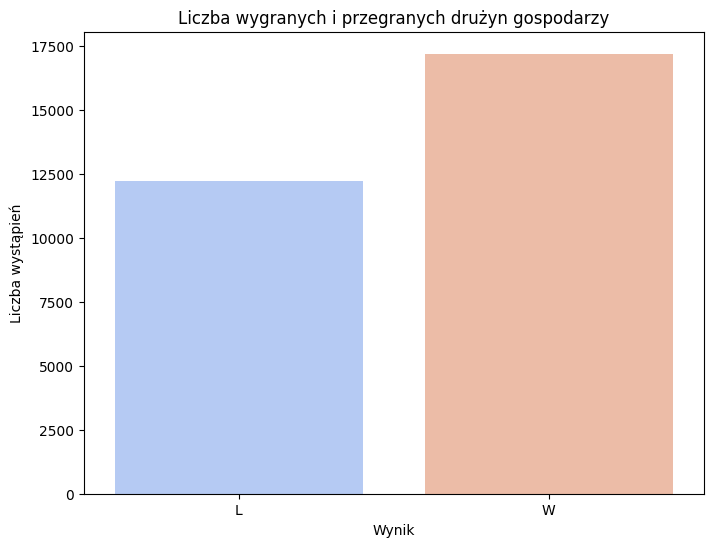

Procent wygranych drużyn gospodarzy: 41.54%
Procent przegranych drużyn gospodarzy: 58.46%


In [18]:

wins_losses = df.groupby('HWL')['HTEAM_ID'].count().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='HWL', y='HTEAM_ID', data=wins_losses, palette='coolwarm')
plt.title('Liczba wygranych i przegranych drużyn gospodarzy')
plt.xlabel('Wynik')
plt.ylabel('Liczba wystąpień')
plt.show()

ratio = wins_losses['HTEAM_ID'][0] / (wins_losses['HTEAM_ID'][0] + wins_losses['HTEAM_ID'][1])
print(f'Procent wygranych drużyn gospodarzy: {ratio * 100:.2f}%')
print(f'Procent przegranych drużyn gospodarzy: {(1 - ratio) * 100:.2f}%')


**Creating a plot depicting the distribution of a feature for the away team and the home team.**

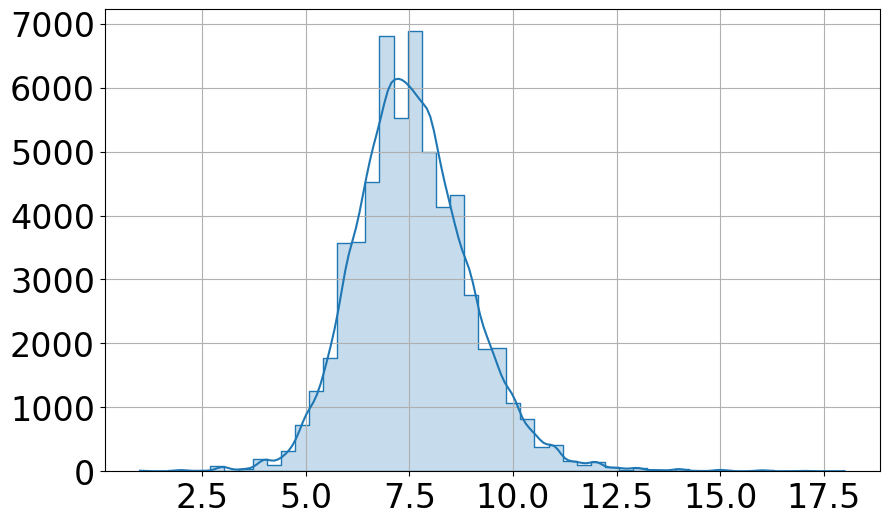

In [69]:
df = pd.read_csv('final1.csv')

def plot_stat_dist_combined(df, stat):
    stat1 = df['H' + stat]
    stat2 = df['A' + stat]
    
    combined = pd.concat([stat1, stat2], axis=0)
    npcombined = np.array(combined.values)
    res = npcombined[:, None]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(res, kde=True, color='blue', bins=50, element='step', legend=False)
    plt.grid(True)
    plt.ylabel(None)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.show()

plot_stat_dist_combined(df, 'STL')

**Comparing the distribution of a feature considering both home and away teams, as well as the wins and losses of the home team**

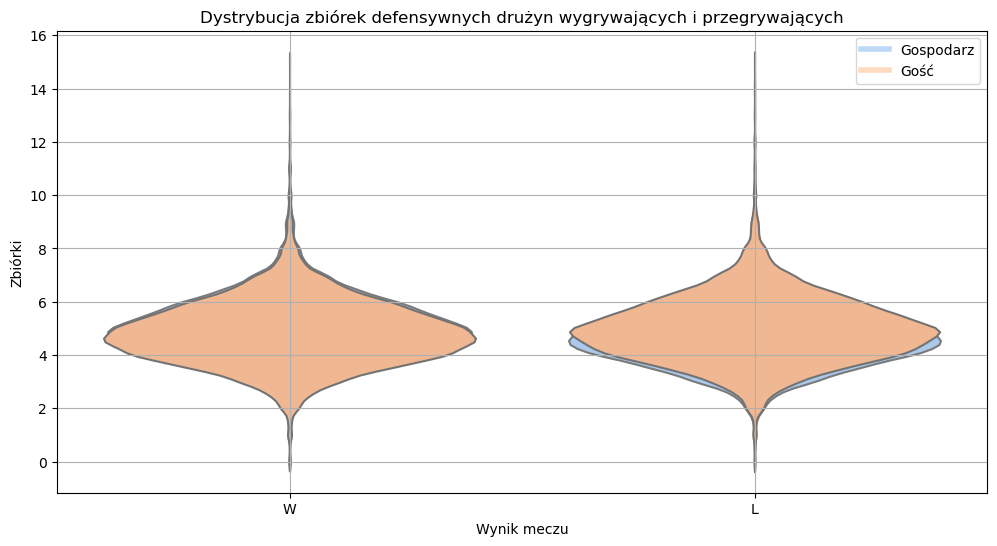

In [91]:

df = pd.read_csv('final1.csv')


plt.figure(figsize=(12, 6))

sns.violinplot(x='HWL', y='HBLK', data=df, inner=None, color=sns.color_palette("pastel")[0], alpha=0.7)
sns.violinplot(x='HWL', y='ABLK', data=df, inner=None, color=sns.color_palette("pastel")[1], alpha=0.5)

plt.title('Dystrybucja zbiórek defensywnych drużyn wygrywających i przegrywających')
plt.ylabel('Zbiórki')
plt.xlabel('Wynik meczu')

legend_data = [plt.Line2D([0], [0], color=sns.color_palette("pastel")[0], lw=4, alpha=0.7),
               plt.Line2D([0], [0], color=sns.color_palette("pastel")[1], lw=4, alpha=0.5)]
plt.legend(legend_data, ['Gospodarz', 'Gość'], loc='upper right')

plt.grid(True)
plt.show()


**Scatter plot showing the relationship between points scored by the home and away teams**

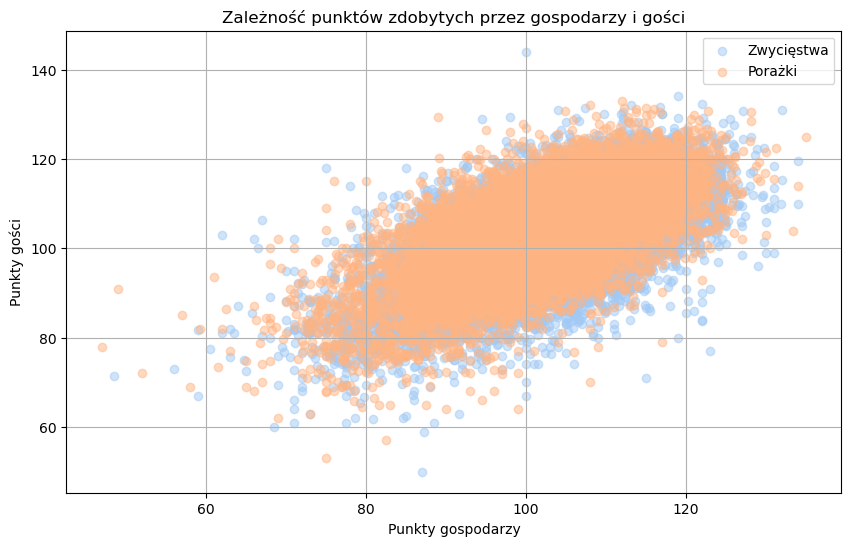

In [96]:
df = pd.read_csv('final1.csv')

plt.figure(figsize=(10, 6))
plt.scatter(df.loc[df['HWL'] == 'W', 'HPTS'], 
            df.loc[df['HWL'] == 'W', 'APTS'], 
            color=sns.color_palette('pastel')[0], 
            alpha=0.5, 
            label='Zwycięstwa')
plt.scatter(df.loc[df['HWL'] == 'L', 'HPTS'],
             df.loc[df['HWL'] == 'L', 'APTS'], 
             color=sns.color_palette('pastel')[1], 
             alpha=0.5, 
             label='Porażki')
plt.title('Zależność punktów zdobytych przez gospodarzy i gości')
plt.xlabel('Punkty gospodarzy')
plt.ylabel('Punkty gości')
plt.legend()
plt.grid(True)
plt.show()

**Correlation matrix**

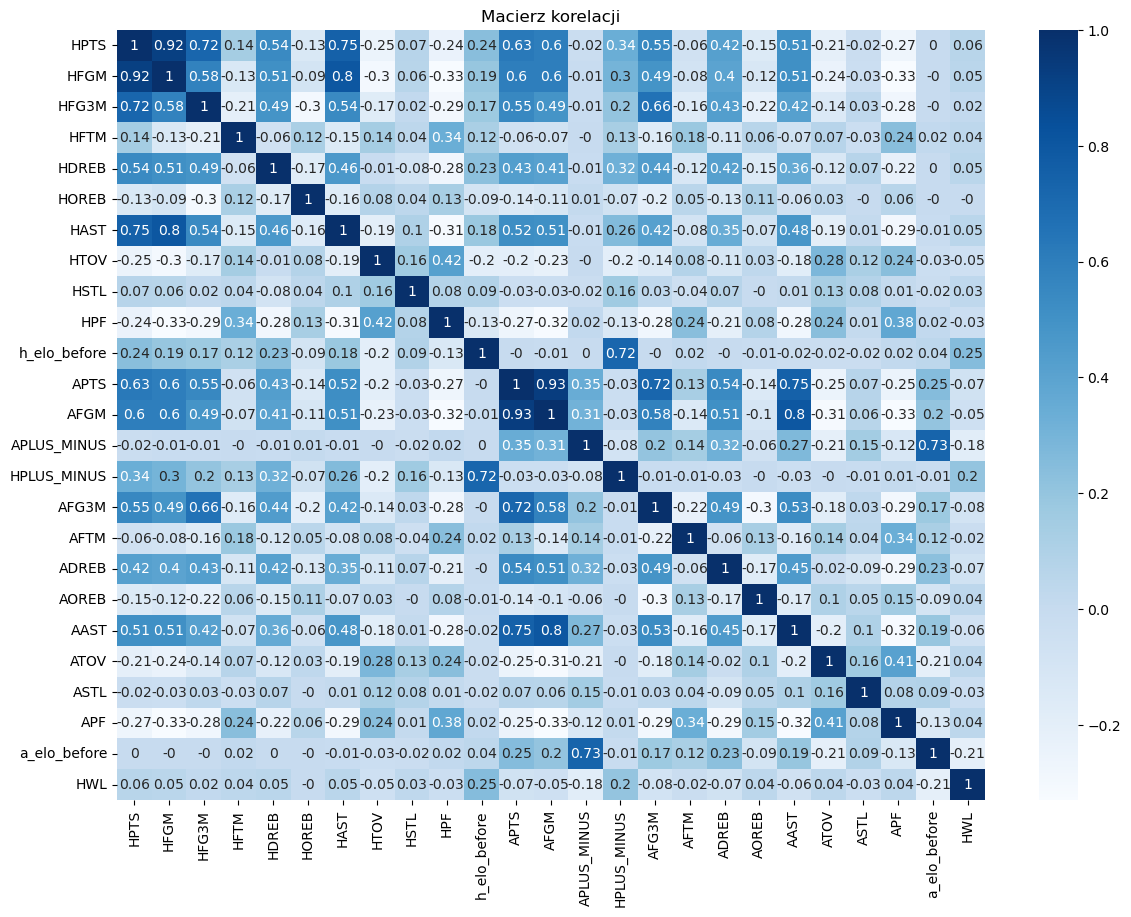

In [17]:
df = pd.read_csv('final1.csv')
plt.figure(figsize=(14, 10))
df['HWL'] = df['HWL'].apply(lambda x: 1 if x == 'W' else 0)
correlation_matrix = df[['HPTS','HFGM','HFG3M', 'HFTM', 
                         'HDREB', 'HOREB', 'HAST',
                          'HTOV', 'HSTL', 'HPF', 
                          'h_elo_before', 'APTS','AFGM',
                          'APLUS_MINUS', 'HPLUS_MINUS',
                           'AFG3M', 'AFTM', 'ADREB', 
                           'AOREB', 'AAST', 'ATOV', 
                           'ASTL', 'APF', 'a_elo_before',
                        'HWL']
                         ].corr()

correlation_matrix_rounded = correlation_matrix.round(2)

sns.heatmap(correlation_matrix_rounded,
             annot=True,
             cmap= 'Blues'
             )
plt.title('Macierz korelacji')
plt.show()


**Chart illustrating the distribution of games over time periods**

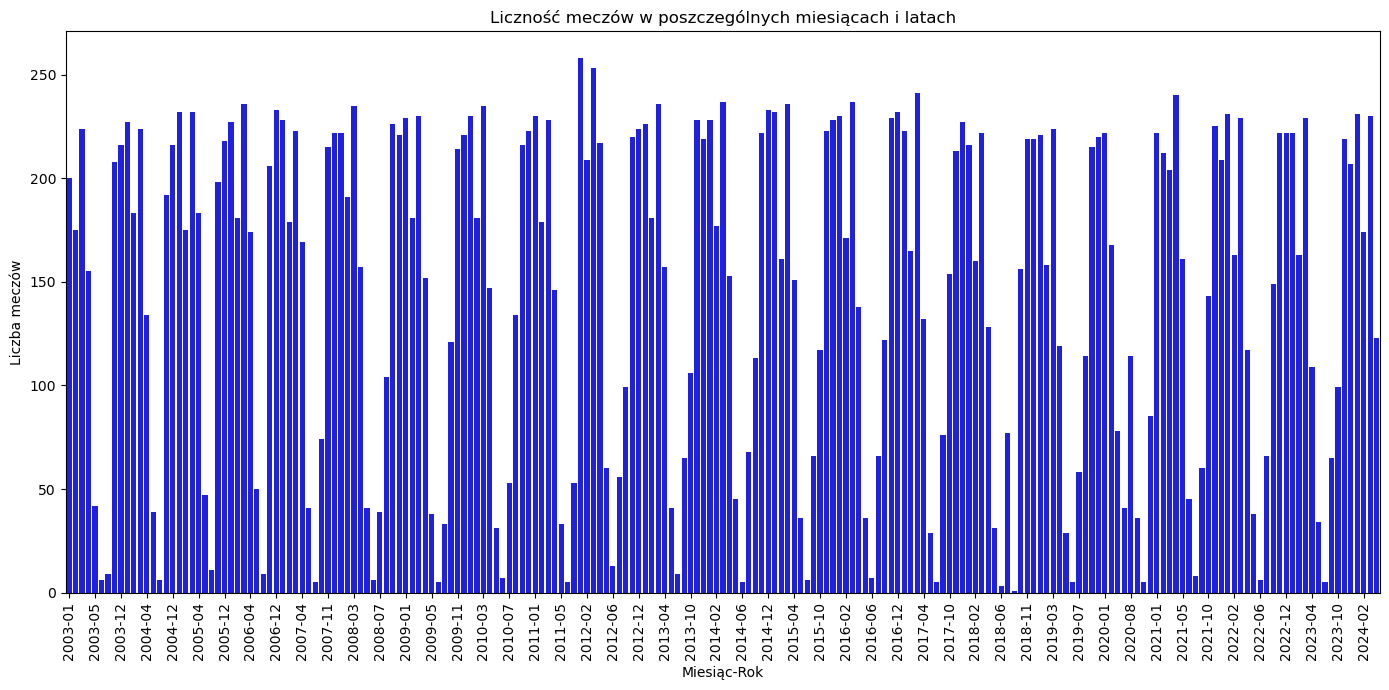

In [33]:
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

df['YEAR'] = df['GAME_DATE'].dt.year
df['MONTH'] = df['GAME_DATE'].dt.month

grouped = df.groupby(['YEAR', 'MONTH']).size().reset_index(name='COUNT')

grouped['MONTH_YEAR'] = grouped['YEAR'].astype(str) + '-' + grouped['MONTH'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 7))
sns.barplot(x='MONTH_YEAR', y='COUNT', data=grouped, color='blue')

plt.title('Liczność meczów w poszczególnych miesiącach i latach')
plt.xlabel('Miesiąc-Rok')
plt.ylabel('Liczba meczów')

xticks = grouped['MONTH_YEAR'].values
plt.xticks(ticks=range(0, len(xticks), 4), labels=xticks[::4], rotation=90)

plt.tight_layout()
plt.show()

**Further distributions to detect potential dependencies**

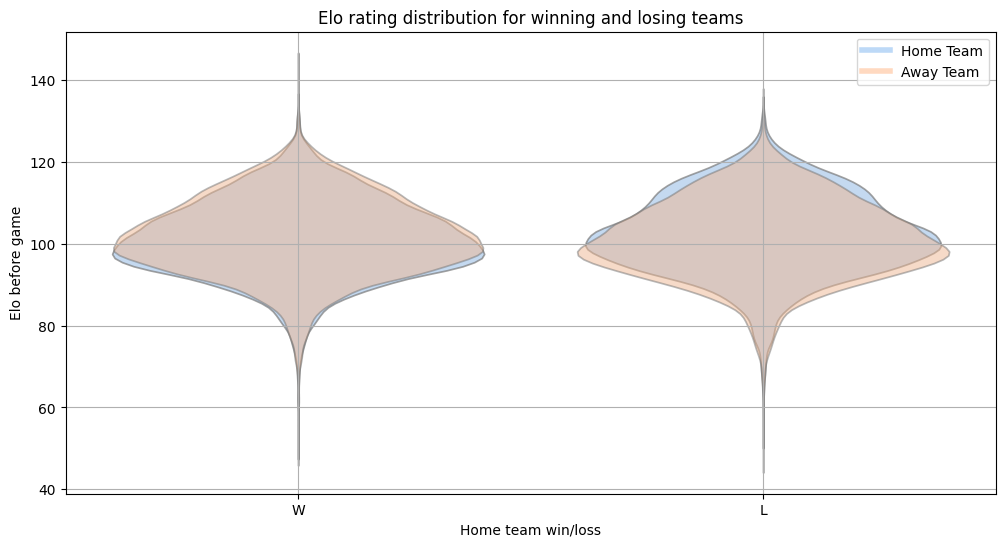

In [8]:

df = pd.read_csv('final1.csv')

plt.figure(figsize=(12, 6))

sns.violinplot(x='HWL', y='APTS', data=df, inner=None, color=sns.color_palette("pastel")[0], alpha=0.7)
sns.violinplot(x='HWL', y='HPTS', data=df, inner=None, color=sns.color_palette("pastel")[1], alpha=0.5)

plt.title('Elo rating distribution for winning and losing teams')
plt.ylabel('Elo before game')
plt.xlabel('Home team win/loss')

legend_data = [plt.Line2D([0], [0], color=sns.color_palette("pastel")[0], lw=4, alpha=0.7),
               plt.Line2D([0], [0], color=sns.color_palette("pastel")[1], lw=4, alpha=0.5)]
plt.legend(legend_data, ['Home Team', 'Away Team'], loc='upper right')

plt.grid(True)
plt.show()



**Generating a dataset report**

In [11]:
profile = ProfileReport(df, title='NBA Games Profiling Report')
profile.to_file('nba_games_profiling.html')

c:\Users\Jędrzej\AppData\Local\Programs\Python\Python39\lib\site-packages\ydata_profiling\profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(
Summarize dataset:  91%|█████████ | 52/57 [00:00<00:00, 83.71it/s, Calculate auto correlation]    c:\Users\Jędrzej\AppData\Local\Programs\Python\Python39\lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Cleveland Cavaliers'')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


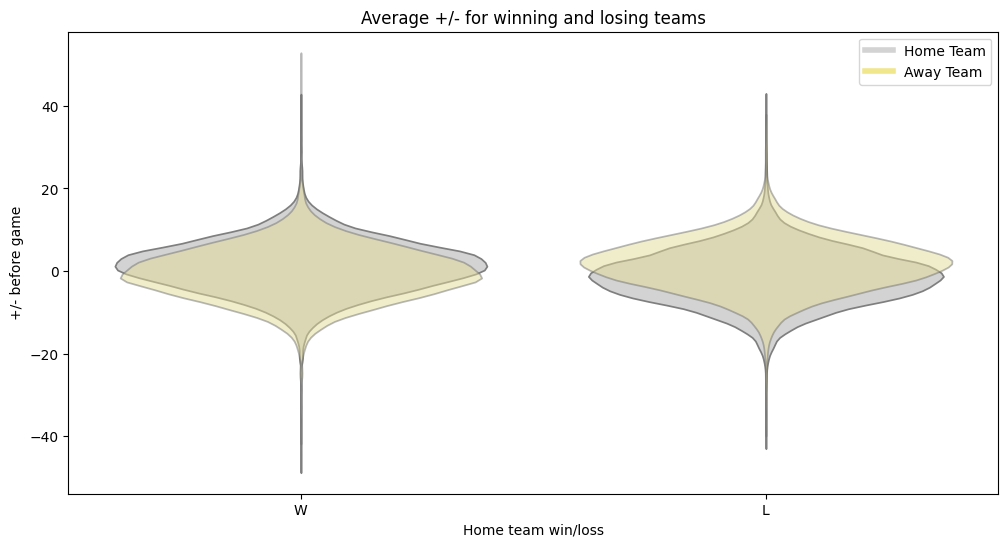

In [79]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='HWL', y='HPLUS_MINUS', data=df, inner=None, color = 'lightgray')
sns.violinplot(x='HWL', y='APLUS_MINUS', data=df, inner=None, color = 'khaki', alpha = 0.5)
plt.title('Average +/- for winning and losing teams')
plt.ylabel('+/- before game')
plt.xlabel('Home team win/loss')
legend_data = [plt.Line2D([0], [0], color='lightgray', lw=4),
               plt.Line2D([0], [0], color='khaki', lw=4),
               plt.Line2D([0], [0], color='lightblue', lw=4),
               plt.Line2D([0], [0], color='pink', lw=4)]
plt.legend(legend_data, ['Home Team', 'Away Team'], loc='upper right')

**EVEN MORE GRAPHS**

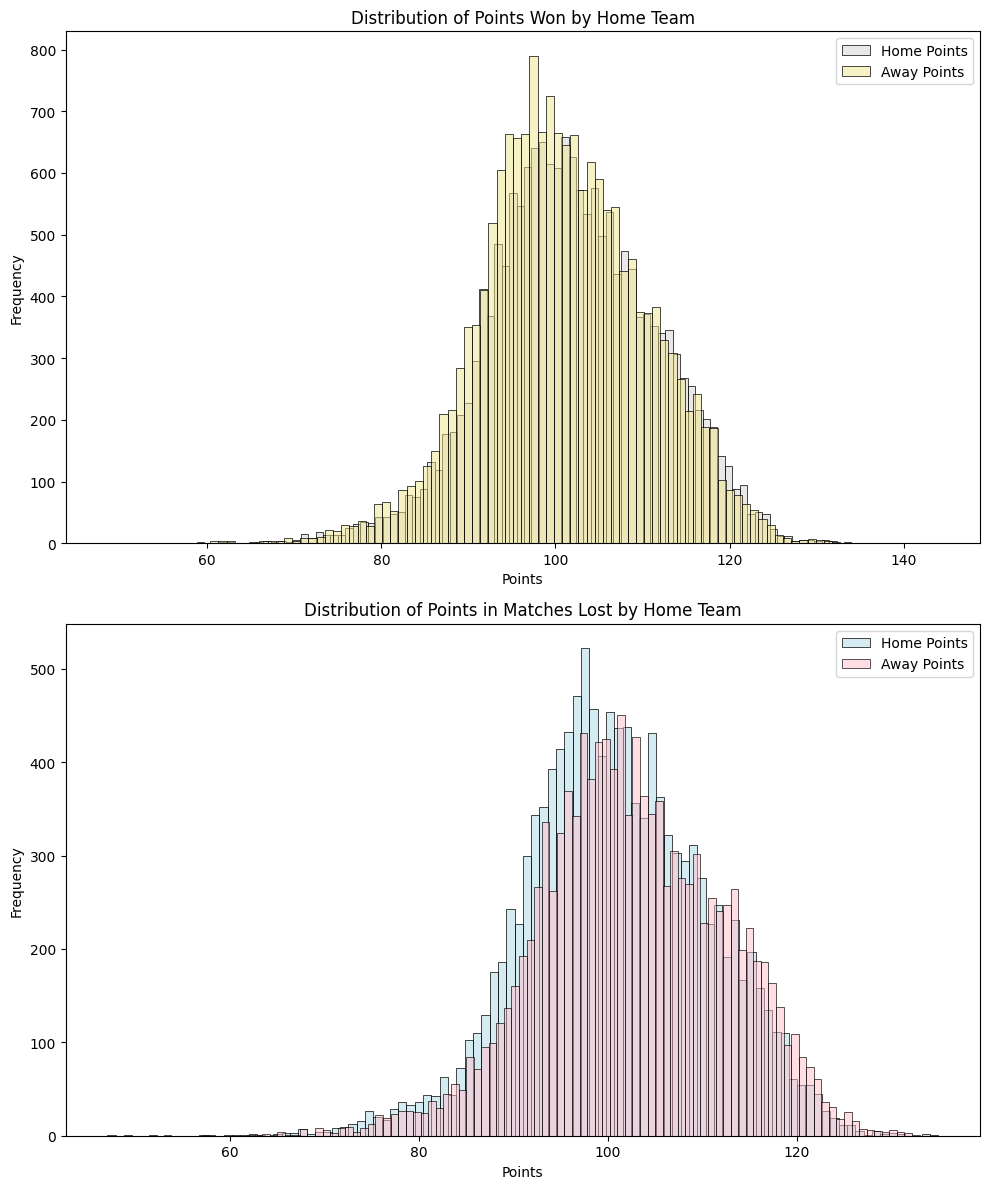

In [136]:
def plot(homestat, awaystat, statdesc):
    df_w = df[df['HWL'] == 'W']
    df_l = df[df['HWL'] == 'L']

    hw_home_points = df_w[homestat]
    hw_away_points = df_w[awaystat]
    hl_home_points = df_l[homestat]
    hl_away_points = df_l[awaystat]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    sns.histplot(hw_home_points, bins=100, color='lightgray', alpha=0.5, label='Home Points', ax=ax1)
    sns.histplot(hw_away_points, bins=100, color='khaki', alpha=0.5, label='Away Points', ax=ax1)
    ax1.set_xlabel('Points')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution of {statdesc} Won by Home Team')
    ax1.legend()

    sns.histplot(hl_home_points, bins=100, color='lightblue', alpha=0.5, label=f'Home {statdesc}', ax=ax2)
    sns.histplot(hl_away_points, bins=100, color='pink', alpha=0.5, label=f'Away {statdesc}', ax=ax2)
    ax2.set_xlabel(statdesc)
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Points in Matches Lost by Home Team')
    ax2.legend()

    plt.tight_layout()  
    plt.show()

plot('HPTS', 'APTS', 'Points')

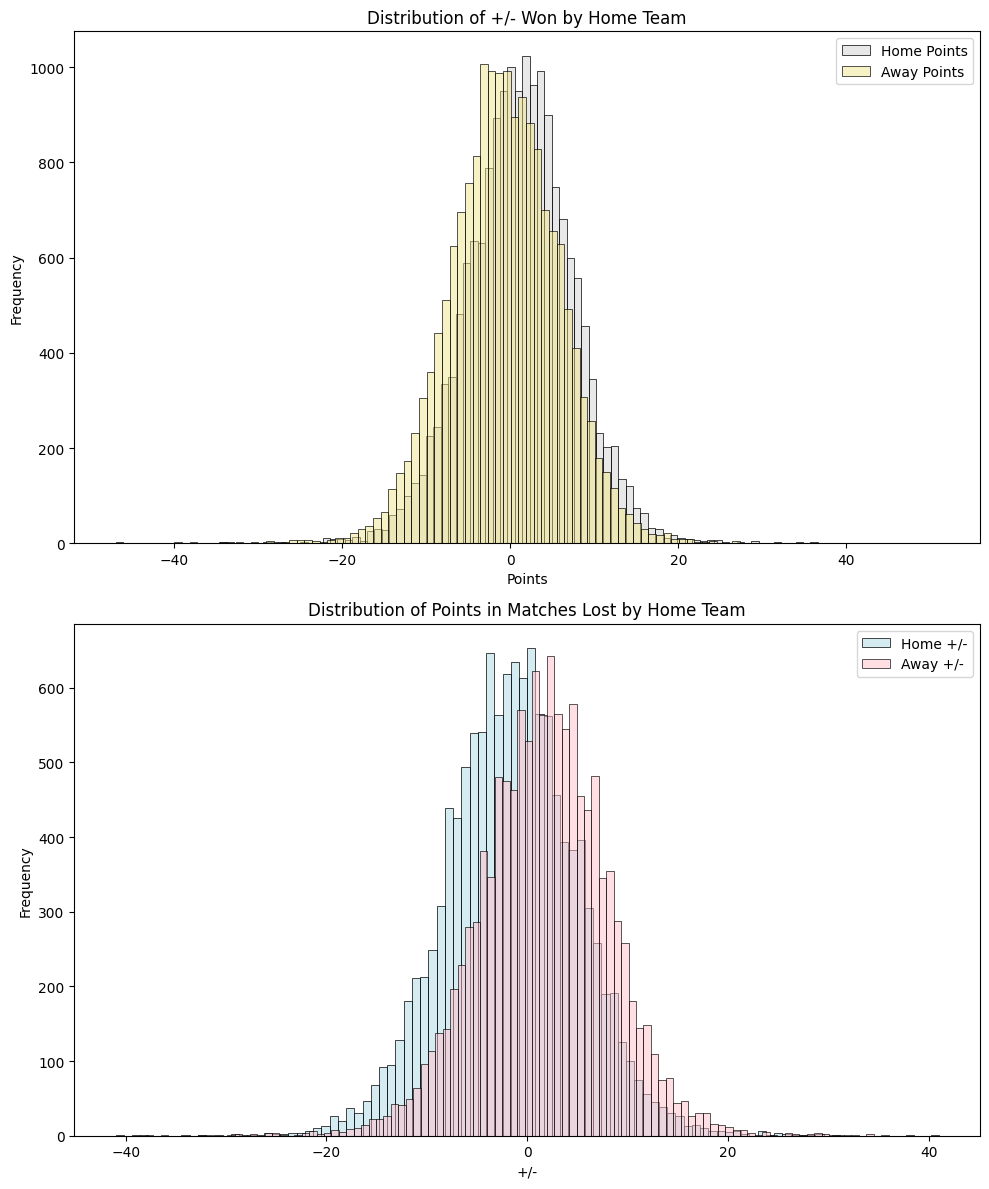

In [137]:
plot('HPLUS_MINUS', 'APLUS_MINUS', '+/-')

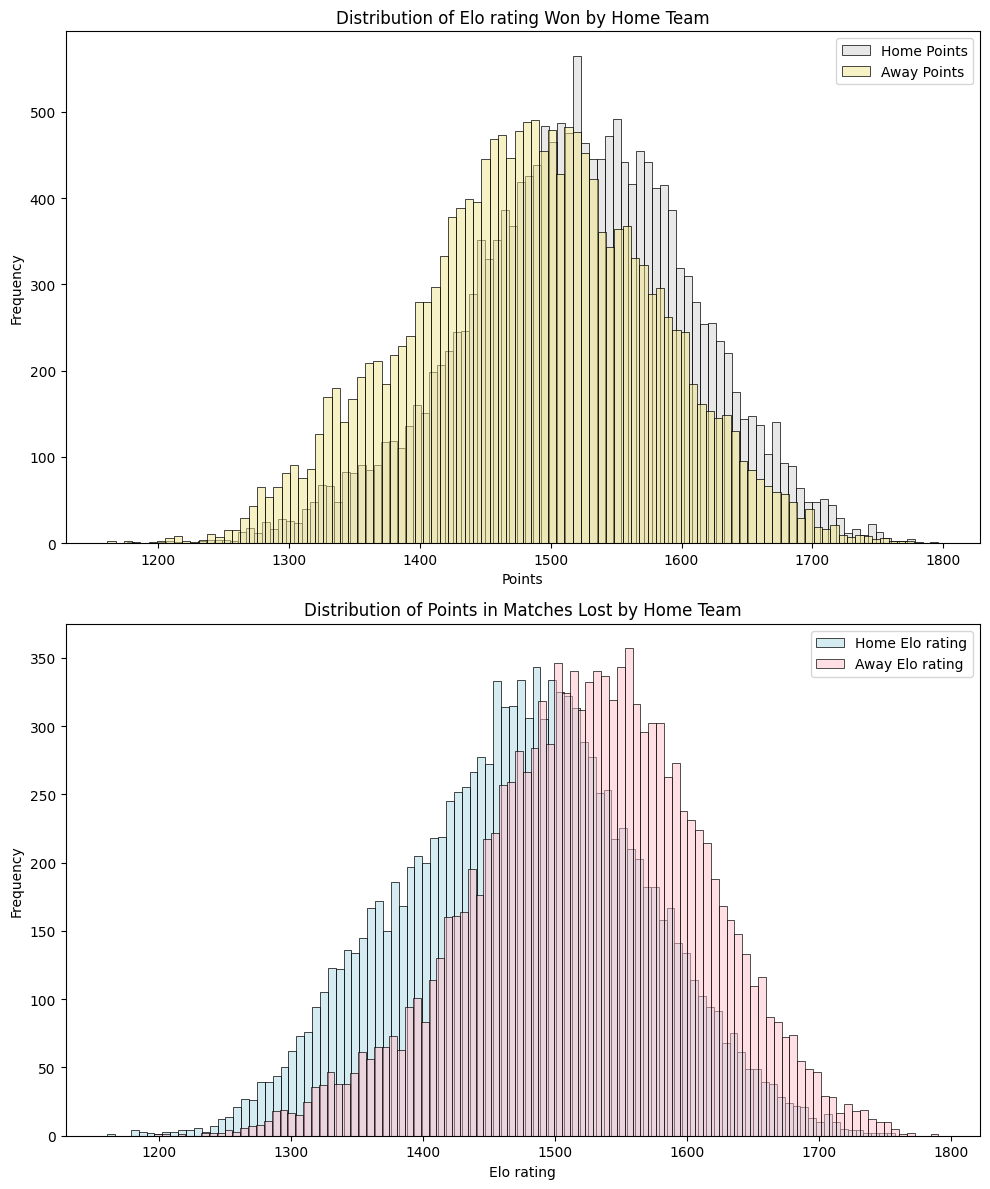

In [138]:
plot('h_elo_before', 'a_elo_before', 'Elo rating')

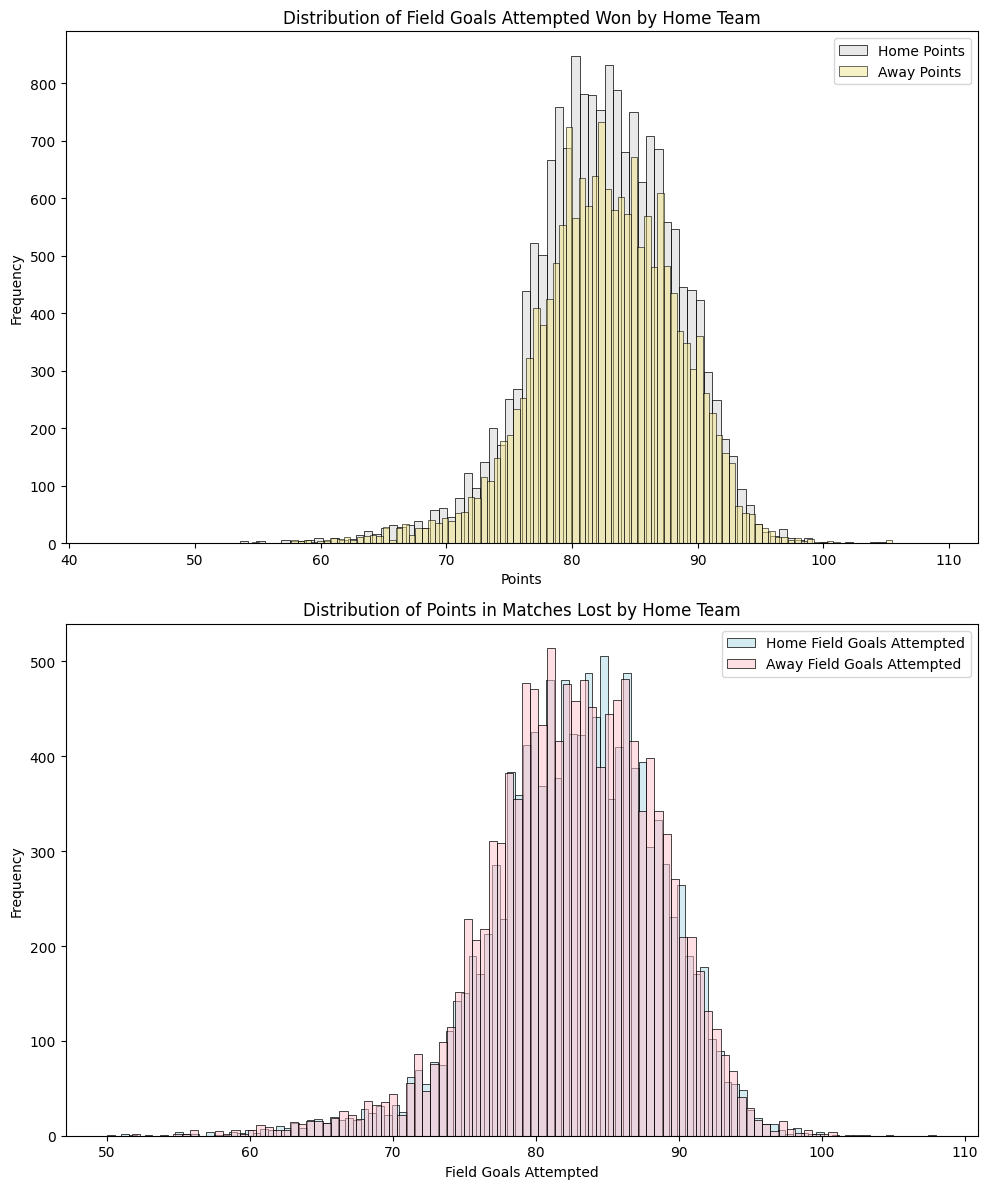

In [139]:
plot('HFGA' , 'AFGA', 'Field Goals Attempted')

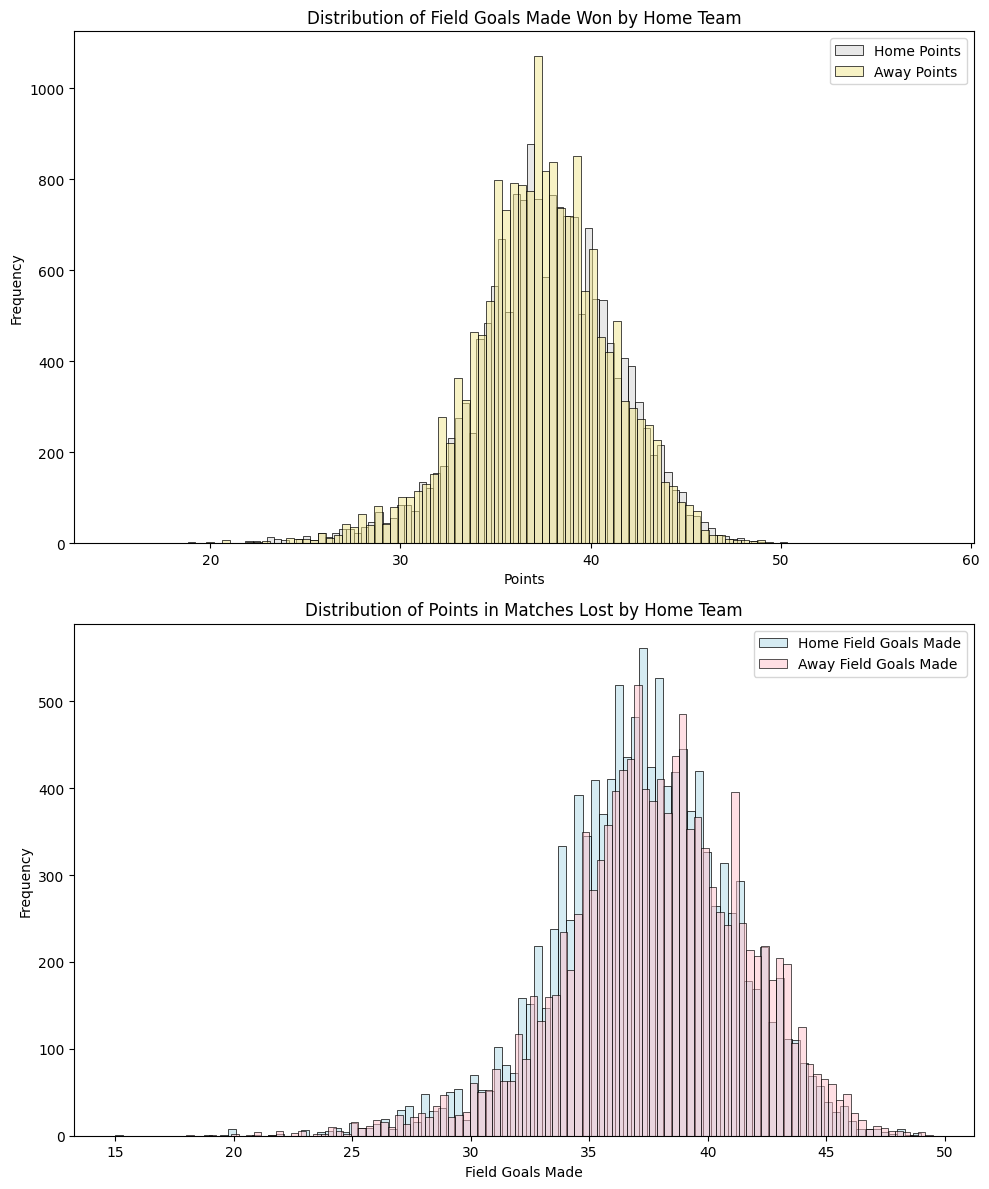

In [140]:
plot('HFGM', 'AFGM', 'Field Goals Made')

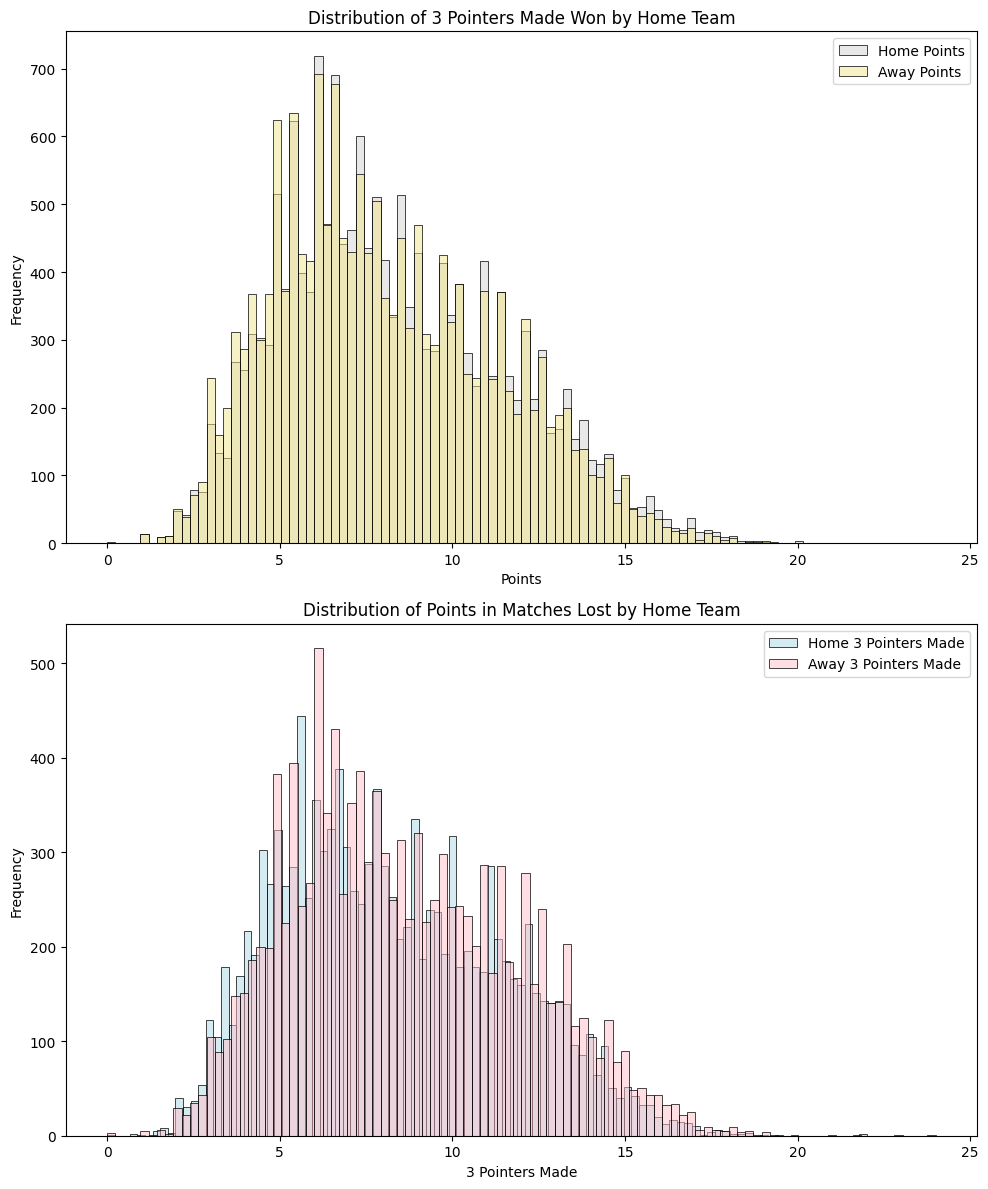

In [141]:
plot('HFG3M', 'AFG3M', '3 Pointers Made')

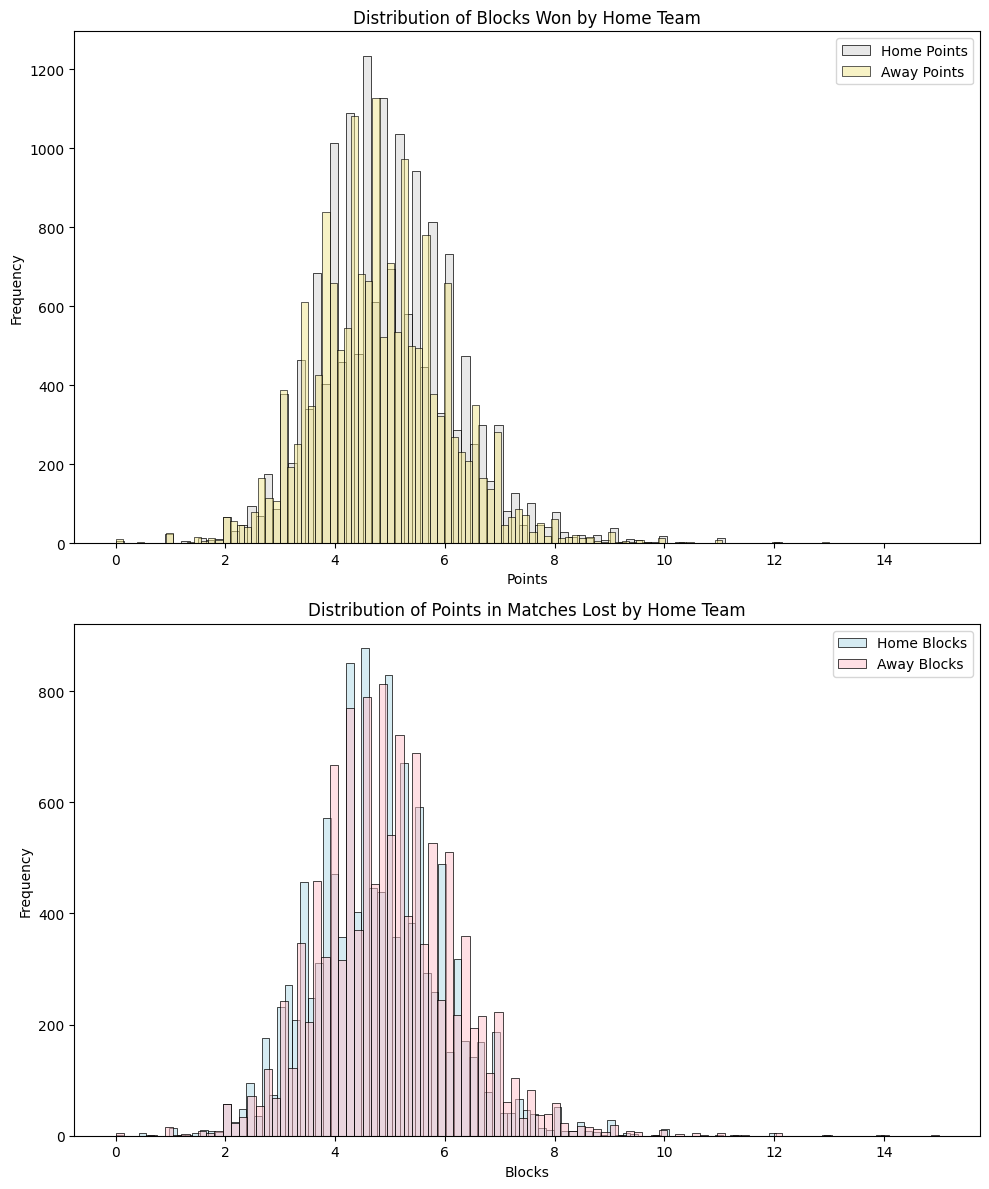

In [142]:
plot('HBLK', 'ABLK', 'Blocks')

# MODELS

* **Dropping irrelevant features for the model**
* **Additionally, we can adjust the number of features we want to include according to our discretion and intuition.**

In [36]:
df = pd.read_csv('final1.csv')
df['HWL'] = df['HWL'].apply(lambda x: 1 if x == 'W' else 0)
df = df.drop(columns = ['SEASON_ID', 'GAME_ID', 'ATEAM_ID', 'HTEAM_ID',
                        'HTEAM_NAME', 'ATEAM_NAME', 'GAME_DATE', 'HMIN', 
                        'AMIN', 'HFG3M', 'AFG3M'])
df

,HWL,HPTS,HFGM,HFGA,HFG_PCT,HFG3A,HFTM,HFTA,HOREB,HDREB,...,ABLK,ATOV,APF,APLUS_MINUS,h_elo_before,a_elo_before,HW,HL,AW,AL
0,1,82.0,33.0,91.0,0.36,13.0,12.0,26.0,11.0,21.0,...,10.0,21.0,24.0,1.0,1475.457475,1504.999432,0.0,1.0,1.0,0.0
1,0,89.0,34.0,77.0,0.44,12.0,17.0,23.0,12.0,24.0,...,5.0,24.0,24.0,20.0,1492.073249,1522.826167,0.0,1.0,1.0,0.0
2,1,102.0,38.0,89.0,0.43,11.0,25.0,30.0,9.0,35.0,...,4.0,15.0,21.0,-18.0,1507.470463,1489.036020,1.0,0.0,0.0,1.0
3,1,107.0,38.0,72.0,0.53,5.0,30.0,34.0,11.0,42.0,...,2.0,19.0,20.0,-2.0,1524.542525,1496.702433,1.0,0.0,0.0,1.0
4,0,96.5,36.5,83.0,0.44,14.0,17.5,22.0,11.5,31.5,...,6.0,21.0,25.0,5.0,1515.089230,1509.008756,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29389,1,97.0,36.0,81.0,0.44,30.0,17.0,21.0,10.0,44.0,...,7.0,12.0,25.0,-14.0,1516.601646,1504.363691,1.0,0.0,0.0,1.0
29390,1,114.0,47.0,102.0,0.46,42.0,5.0,6.0,15.0,34.0,...,7.0,12.0,15.0,-11.0,1618.471476,1540.560563,1.0,0.0,0.0,1.0
29391,0,109.0,41.0,87.0,0.47,37.0,13.0,13.0,5.0,42.0,...,5.0,12.0,16.0,-15.0,1528.670967,1553.113697,1.0,0.0,0.0,1.0
29392,0,109.0,40.0,87.0,0.46,36.0,11.0,13.0,10.0,35.0,...,9.0,8.0,15.0,-12.0,1532.261662,1560.781875,1.0,0.0,0.0,1.0


**Division into dependent and independent variables**

In [3]:
label = df['HWL']
features = df.drop(columns = 'HWL')

**Splitting into training and testing sets**

In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2)

* **Logistic Regression**
* **Logistic regression with default parameters**
* **Displaying the confusion matrix**
* **Displaying the accuracy report of the model**

              precision    recall  f1-score   support

        Loss       0.63      0.46      0.53      2522
         Win       0.66      0.80      0.72      3357

    accuracy                           0.65      5879
   macro avg       0.65      0.63      0.63      5879
weighted avg       0.65      0.65      0.64      5879



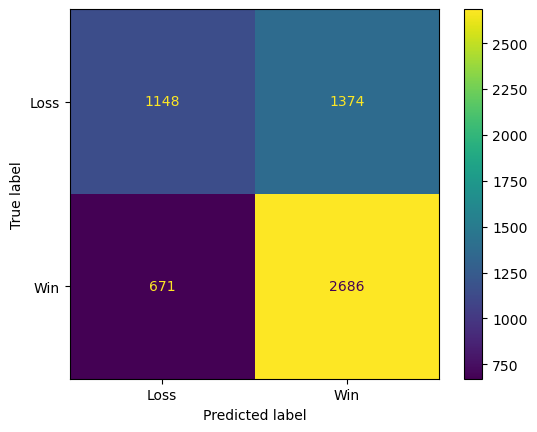

In [169]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)


disp = ConfusionMatrixDisplay.from_estimator(
    pipe,
    x_test,
    y_test,
    display_labels=['Loss', 'Win'],
    cmap='viridis'
)


report = classification_report(y_test, 
                               pipe.predict(x_test), 
                               target_names=['Loss', 'Win']
                               )
print(report)

**Model Hyperparameter Optimization**

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

lr = LogisticRegression(max_iter=200)

param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', None],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

LR_search = GridSearchCV(lr, param_grid=param_dist, refit=True, verbose=3, cv=5)
LR_search.fit(X_train_scaled, y_train)
print("Best Parameters:", LR_search.best_params_)

disp = ConfusionMatrixDisplay.from_estimator(
    LR_search.best_estimator_ ,
    X_test_scaled,
    y_test,
    display_labels=['Loss', 'Win'],
        cmap='viridis'
)

report = classification_report(y_test,
                                 LR_search.best_estimator_.predict(X_test_scaled),
                                 target_names=['Loss', 'Win']
                                 )
print(report)


Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV 1/5] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.660 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solv

c:\Users\Jedrzej\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.001, penalty=None, solver=newton-cg;, score=0.660 total time=   0.3s


c:\Users\Jedrzej\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=0.001, penalty=None, solver=newton-cg;, score=0.665 total time=   0.3s


c:\Users\Jedrzej\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


KeyboardInterrupt: 

**Support Vector Machine Classification Model**


              precision    recall  f1-score   support

        Loss       0.61      0.37      0.46      2427
         Win       0.65      0.83      0.73      3452

    accuracy                           0.64      5879
   macro avg       0.63      0.60      0.60      5879
weighted avg       0.63      0.64      0.62      5879



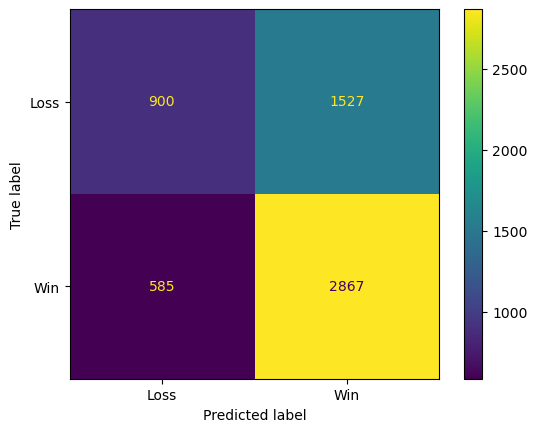

In [8]:
model = SVC(C = 100, gamma=1, kernel='linear')
model.fit(x_train, y_train)

disp = ConfusionMatrixDisplay.from_estimator(
    model,
    x_test,
    y_test,
    display_labels=['Loss', 'Win'],
    cmap='viridis'
)

raport = classification_report(y_test,
                                    pipe.predict(x_test),
                                    target_names=['Loss', 'Win']
                                    )
print(raport)

**Hyperparameter Optimization**

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 2.6min
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 2.5min
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 2.4min
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 2.8min
[CV] END ........................C=1, gamma=1, kernel=linear; total time= 3.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.9min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.9min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 2.0min
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time= 2.6min
[CV] END ......................C=1, gamma=0.1, 

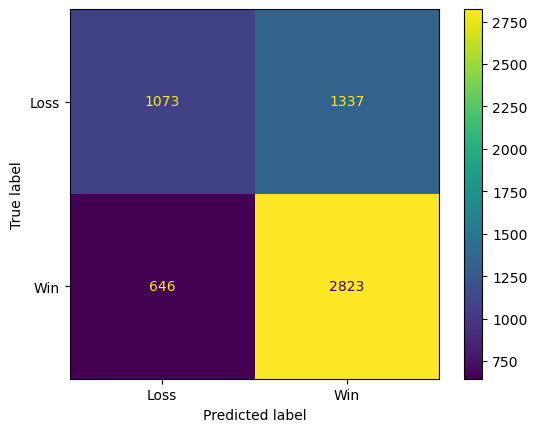

In [6]:
param_grid = {'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              'kernel':['linear','rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(x_train, y_train)
print(grid.best_params_)
disp = ConfusionMatrixDisplay.from_estimator(
    grid.best_estimator_,
    x_test,
    y_test,
    display_labels=['Loss', 'Win'],
    cmap='viridis'
)
raport = classification_report(y_test,
                                    grid.best_estimator_.predict(x_test),
                                    target_names=['Loss', 'Win']
                                    )

**Comparison of Accuracy after Scaling**

In [14]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(float))
x_test_scaled = scaler.transform(x_test.astype(float))

model = LogisticRegression(max_iter=10000)
model.fit(x_train_scaled, y_train)

model2 = SVC(random_state=42)
model2.fit(x_train_scaled, y_train)

print(f"Accuracy: {model.score(x_test_scaled, y_test)}")
print(f"Accuracy: {model2.score(x_test_scaled, y_test)}")

Accuracy: 0.658955604694676
Accuracy: 0.6533424051709474
